In [1]:
ticker = "BTCUSDT"
timeframe = "D1"
fast_sma_period = 35
slow_sma_period = 300
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
df = pd.read_csv(f"/content/btc_6h.csv", parse_dates=['datetime'])

In [4]:
import plotly.graph_objects as go

In [5]:
figure = go.Figure(

    data = [
            go.Candlestick(
            x = df["datetime"],
            low = df['low'],
            high = df['high'],
            close = df['close'],
            open = df['open'],
            increasing_line_color = 'green',
            decreasing_line_color = 'black'
        )
    ]
)
figure.update_layout(
        title = 'Bitcoin Stock Prices',
        yaxis_title = 'Bitcoin stock prices ($)',
        xaxis_title = 'Date')
figure.show()

In [6]:
df.set_index('datetime', inplace=True)

In [7]:
!pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.6 MB/s eta 0:00:00


In [8]:
import backtrader as bt
import backtrader.analyzers as btanalyzers

In [9]:
class SMACrossStrategy(bt.Strategy):
    """ Live strategy demonstration with SMA """
    params = (
        ("fast_sma_period", 50),
        ("slow_sma_period", 200),
        ('timeframe', ''),
    )

    def __init__(self):
        self.fast_sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.fast_sma_period)
        self.slow_sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.slow_sma_period)

    def next(self):
        """The arrival of a new ticker bar"""
        for data in self.datas:  # We run through all the requested bars of all tickers
            ticker = data._name
            _interval = self.p.timeframe
            _date = bt.num2date(data.datetime[0])
            print('{} / {} [{}] - Open: {}, High: {}, Low: {}, Close: {}, Volume: {}'.format(bt.num2date(data.datetime[0]), data._name, _interval, data.open[0], data.high[0], data.low[0], data.close[0], data.volume[0], ))

            # Check for crossover
            if self.fast_sma > self.slow_sma and self.position.size == 0:
                free_money = self.broker.getcash()
                price = data.close[0]  # by close price
                size = (free_money / price) * 0.1  # 10% of free money
                self.buy(data=data, exectype=bt.Order.Limit, price=price, size=size)

            # Check for crossunder
            elif self.fast_sma < self.slow_sma and self.position.size > 0:
                self.close()
    def notify_order(self, order):
        """Changing the status of the order"""
        order_data_name = order.data._name  # The name of the ticker from the order
        print("*" * 50)
        self.log(f'Order number {order.ref} {order.info["order_number"]} {order.getstatusname()} {"Buy" if order.isbuy() else "Sell"} {order_data_name} {order.size} @ {order.price}')
        if order.status == bt.Order.Completed:  # If the order is fully executed
            if order.isbuy():  # if the order is buy
                self.log(f'Buy {order_data_name} Price: {order.executed.price:.2f}, Val: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
            else:  # if the order is sell
                self.log(f'Sell {order_data_name} Price: {order.executed.price:.2f}, Val: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
        print("*" * 50)

    def notify_trade(self, trade):
        """Changing the position status"""
        if trade.isclosed:  # If the position is closed
            self.log(f'Profit on a closed position {trade.getdataname()} Total={trade.pnl:.2f}, Comm={trade.pnlcomm:.2f}')

    def log(self, txt, dt=None):
        """Output a date string to the console"""
        dt = bt.num2date(self.datas[0].datetime[0]) if not dt else dt  # The set date or the date of the current bar
        print(f'{dt.strftime("%d.%m.%Y %H:%M")}, {txt}')  # Output the date and time with the specified text to the console

In [10]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission=0.0015)

In [11]:
data = bt.feeds.PandasData(dataname=df, name=ticker)
cerebro.adddata(data)

In [12]:
cerebro.addstrategy(SMACrossStrategy, timeframe=timeframe, fast_sma_period=fast_sma_period, slow_sma_period=slow_sma_period)

0

In [13]:
cerebro.addanalyzer(btanalyzers.SQN, _name='SQN')
cerebro.addanalyzer(btanalyzers.VWR, _name='VWR', fund=True)
cerebro.addanalyzer(btanalyzers.TimeDrawDown, _name='TDD', fund=True, timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='DD', fund=True)
cerebro.addanalyzer(btanalyzers.Returns, _name='R', fund=True, timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(btanalyzers.AnnualReturn, _name='AR', )
cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='SR')
cerebro.addanalyzer(btanalyzers.TradeAnalyzer, _name='TradeAnalyzer')

In [14]:
print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

Starting Portfolio Value: 100000.00


In [15]:
results = cerebro.run()
thestrat = results[0]

Streaming output truncated to the last 5000 lines.
2018-10-24 11:30:00 / BTCUSDT [D1] - Open: 6615.91, High: 6622.0, Low: 6591.0, Close: 6600.53, Volume: 3212.376693
2018-10-24 17:30:00 / BTCUSDT [D1] - Open: 6600.53, High: 6620.11, Low: 6574.61, Close: 6594.82, Volume: 2773.244272
2018-10-24 23:30:00 / BTCUSDT [D1] - Open: 6594.83, High: 6596.88, Low: 6555.0, Close: 6565.5, Volume: 2815.163637
2018-10-25 05:30:00 / BTCUSDT [D1] - Open: 6566.81, High: 6575.09, Low: 6502.8, Close: 6539.01, Volume: 4647.897485
2018-10-25 11:30:00 / BTCUSDT [D1] - Open: 6539.01, High: 6560.0, Low: 6531.65, Close: 6546.0, Volume: 2724.660476
2018-10-25 17:30:00 / BTCUSDT [D1] - Open: 6544.99, High: 6570.0, Low: 6541.0, Close: 6547.74, Volume: 1819.263204
2018-10-25 23:30:00 / BTCUSDT [D1] - Open: 6545.12, High: 6563.82, Low: 6528.0, Close: 6528.09, Volume: 1150.880079
2018-10-26 05:30:00 / BTCUSDT [D1] - Open: 6528.13, High: 6547.47, Low: 6523.19, Close: 6538.5, Volume: 3422.630281
2018-10-26 11:30:00 / BT

In [16]:
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Remaining available funds: %.2f' % cerebro.broker.getcash())
print('Assets in the amount of: %.2f' % (cerebro.broker.getvalue() - cerebro.broker.getcash()))
print()
print('SQN: ', thestrat.analyzers.SQN.get_analysis())
print('VWR: ', thestrat.analyzers.VWR.get_analysis())
print('TDD: ', thestrat.analyzers.TDD.get_analysis())
print('DD: ', thestrat.analyzers.DD.get_analysis())
print('AR: ', thestrat.analyzers.AR.get_analysis())
print('Profitability: ', thestrat.analyzers.R.get_analysis())

Ending Portfolio Value: 152542.53
Remaining available funds: 152542.53
Assets in the amount of: 0.00

SQN:  AutoOrderedDict([('sqn', 1.3202800135161423), ('trades', 15)])
VWR:  OrderedDict([('vwr', 3.337816818369527)])
TDD:  OrderedDict([('maxdrawdown', 9.931258890256364), ('maxdrawdownperiod', 525)])
DD:  AutoOrderedDict([('len', 1167), ('drawdown', 7.5211713839830825), ('moneydown', 12.406066853821244), ('max', AutoOrderedDict([('len', 2156), ('drawdown', 10.186931494485574), ('moneydown', 16.803200818561407)]))])
AR:  OrderedDict([(2018, -0.04202872007034941), (2019, 0.17288321342774982), (2020, 0.15432906750166353), (2021, 0.17612656840643282), (2022, 0.0)])
Profitability:  OrderedDict([('rtot', 0.4222732728948828), ('ravg', 0.0002830249818330314), ('rnorm', 0.07392729194727905), ('rnorm100', 7.392729194727905)])


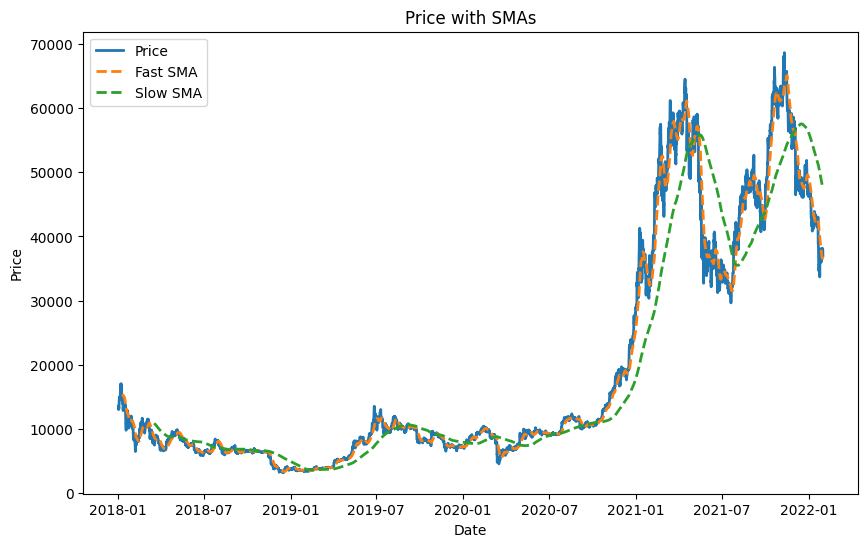

In [17]:
dates = df.index  # Assuming your DataFrame has a datetime index
prices = df['close'].values
fast_sma = results[0].fast_sma.array
slow_sma = results[0].slow_sma.array

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, label='Price', linewidth=2)
plt.plot(dates, fast_sma, label='Fast SMA', linestyle='--', linewidth=2)
plt.plot(dates, slow_sma, label='Slow SMA', linestyle='--', linewidth=2)

plt.title('Price with SMAs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()